In [18]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import hnn_core
from hnn_core import (jones_2009_model, simulate_dipole,
                      read_network_configuration, read_dipole, JoblibBackend)
from hnn_core.viz import plot_dipole
from scipy.stats import norm
import pickle
from scipy.interpolate import CubicSpline
from joblib import Parallel, delayed


In [97]:
tstop = 250
def run_net(net, tstop=250):
    with JoblibBackend(n_jobs=20):
        dpl = simulate_dipole(net, tstop=tstop, dt=0.025, n_trials=10)
    return net, dpl

fpath = '../data/network_configurations'
net_default = read_network_configuration(f'{fpath}/default.json')
net_times = read_network_configuration(f'{fpath}/drive_times.json')
net_strengths = read_network_configuration(f'{fpath}/drive_strengths.json')
net_optimized = read_network_configuration(f'{fpath}/../opt_baseline_config_correlation_best.json')


net_names = ['Initial', 'Drive times', 'Drive strengths', 'Optimized']
net_configs = [net_default, net_times, net_strengths, net_optimized]

res = [run_net(net) for net in net_configs]

In [83]:
smooth_window = 40
scale_factor = 3000

# Load network and dipole into lists
# dpl_list = [dpl[0].copy().smooth(smooth_window).scale(scale_factor) for (net, dpl) in res]
dpl_list = [dpl for (net, dpl) in res]
net_list = [net for (net, dpl) in res]
times = res[0][1][0].times

# Resample target waveform
dipole_experimental = read_dipole('../data/L_Contra.txt')
baseline_cs = CubicSpline(dipole_experimental.times, dipole_experimental.data['agg'])
baseline_dpl = baseline_cs(times)


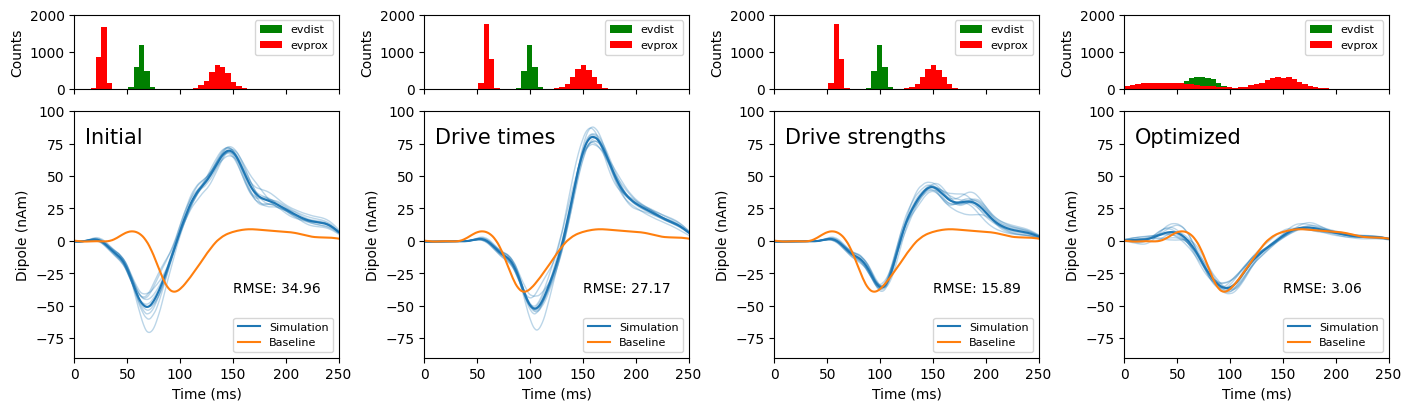

In [122]:
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(14, 4), height_ratios=(0.3, 1),
                         constrained_layout=True)

scale_factor_list = [3000, 3000, 3000, 1000]
for col_idx in range(4):
    dpl_plot = [dpl_trial.copy().smooth(smooth_window).scale(scale_factor_list[col_idx]).data['agg'] for dpl_trial in dpl_list[col_idx]]

    net_list[col_idx].cell_response.plot_spikes_hist(ax=axes[0, col_idx], spike_types=['evprox', 'evdist'], show=False)
    axes[0, col_idx].set_ylim(0, 2000)
    axes[0, col_idx].legend(fontsize=8)

    axes[1, col_idx].plot(times, np.array(dpl_plot).T, color='C0', alpha=0.3, linewidth=1)
    avg_dpl = np.mean(dpl_plot, axis=0)
    axes[1, col_idx].plot(times, avg_dpl, color='C0', label='Simulation')
    axes[1, col_idx].plot(times, baseline_dpl, color='C1', label='Baseline')

    rmse = (np.sqrt(np.sum((avg_dpl - baseline_dpl) ** 2)) / len(avg_dpl)) * 100 # need to check why 100 needed to match GUI
    axes[1, col_idx].set_ylim(-90, 100)
    axes[1, col_idx].set_xlabel('Time (ms)')
    axes[1, col_idx].text(150, -40, f'RMSE: {rmse:.2f}')
    axes[1, col_idx].text(10, 75, net_names[col_idx], fontsize=15)
    axes[1, col_idx].legend(loc='lower right', fontsize=8)

    _ = axes[1, col_idx].set_ylabel('Dipole (nAm)')
plt.savefig('../figures/baseline_optimization_sequence.svg')


In [123]:
def _corr_evoked():
    pass

def set_params():
    pass

with open('../data/opt_baseline_object_correlation_best.pkl', 'rb') as file:
    opt_run = pickle.load(file)

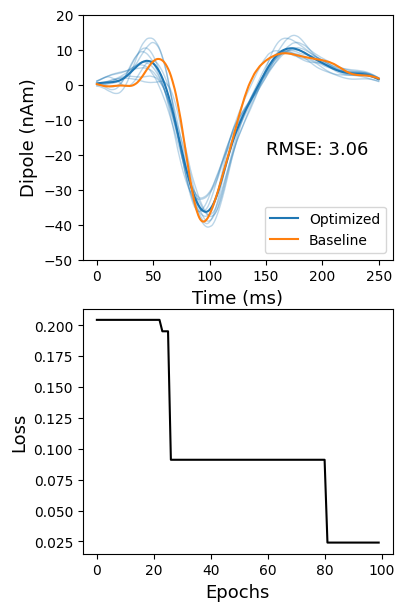

In [126]:
labelsize=13
ticksize = 10

plt.figure(figsize=(4,7))

dpl_plot = [dpl_trial.copy().smooth(smooth_window).scale(scale_factor_list[col_idx]).data['agg'] for dpl_trial in dpl_list[-1]]

plt.subplot(2,1,1)
plt.plot(times, np.array(dpl_plot).T, color='C0', alpha=0.3, linewidth=1)
avg_dpl = np.mean(dpl_plot, axis=0)
plt.plot(times, avg_dpl, color='C0', label='Optimized')
plt.plot(times, baseline_dpl, color='C1', label='Baseline')

rmse = (np.sqrt(np.sum((avg_dpl - baseline_dpl) ** 2)) / len(avg_dpl)) * 100
plt.ylim(-50, 20)
plt.xlabel('Time (ms)')
plt.text(150, -20, f'RMSE: {rmse:.2f}', fontsize=13)
plt.legend(loc='lower right', fontsize=10)

plt.xlabel('Time (ms)', fontsize=labelsize)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

plt.subplot(2,1,2)
plt.plot(opt_run.obj_, color='k')
plt.xlabel('Epochs', fontsize=labelsize)
plt.ylabel('Loss', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)
plt.savefig('../figures/baseline_optimization_results.svg')
